In [1]:
import cartopy.crs as ccrs
import easygems.healpix as egh
import intake
import matplotlib.pyplot as plt

/home/users/mmuetz/miniforge3/envs/hackathon_env/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The return type of `Dataset.dims` will be changed.*"
)

In [3]:
cat = intake.open_catalog('https://raw.githubusercontent.com/digital-earths-global-hackathon/catalog/refs/heads/main/online/main.yaml')

In [4]:
sim = cat['um_glm_n2560_RAL3p3']

In [5]:
dss = {}
for z in range(10, -1, -1):
    print(z)
    dss[z] = sim(zoom=z, time='PT1H').to_dask()


10
9
8
7
6
5
4
3
2


ClientResponseError: 503, message='Service Unavailable', url='https://hackathon-o.s3-ext.jc.rl.ac.uk/sim-data/dev/v5/glm.n2560_RAL3p3/um.PT1H.hp_z2.zarr/.zmetadata'

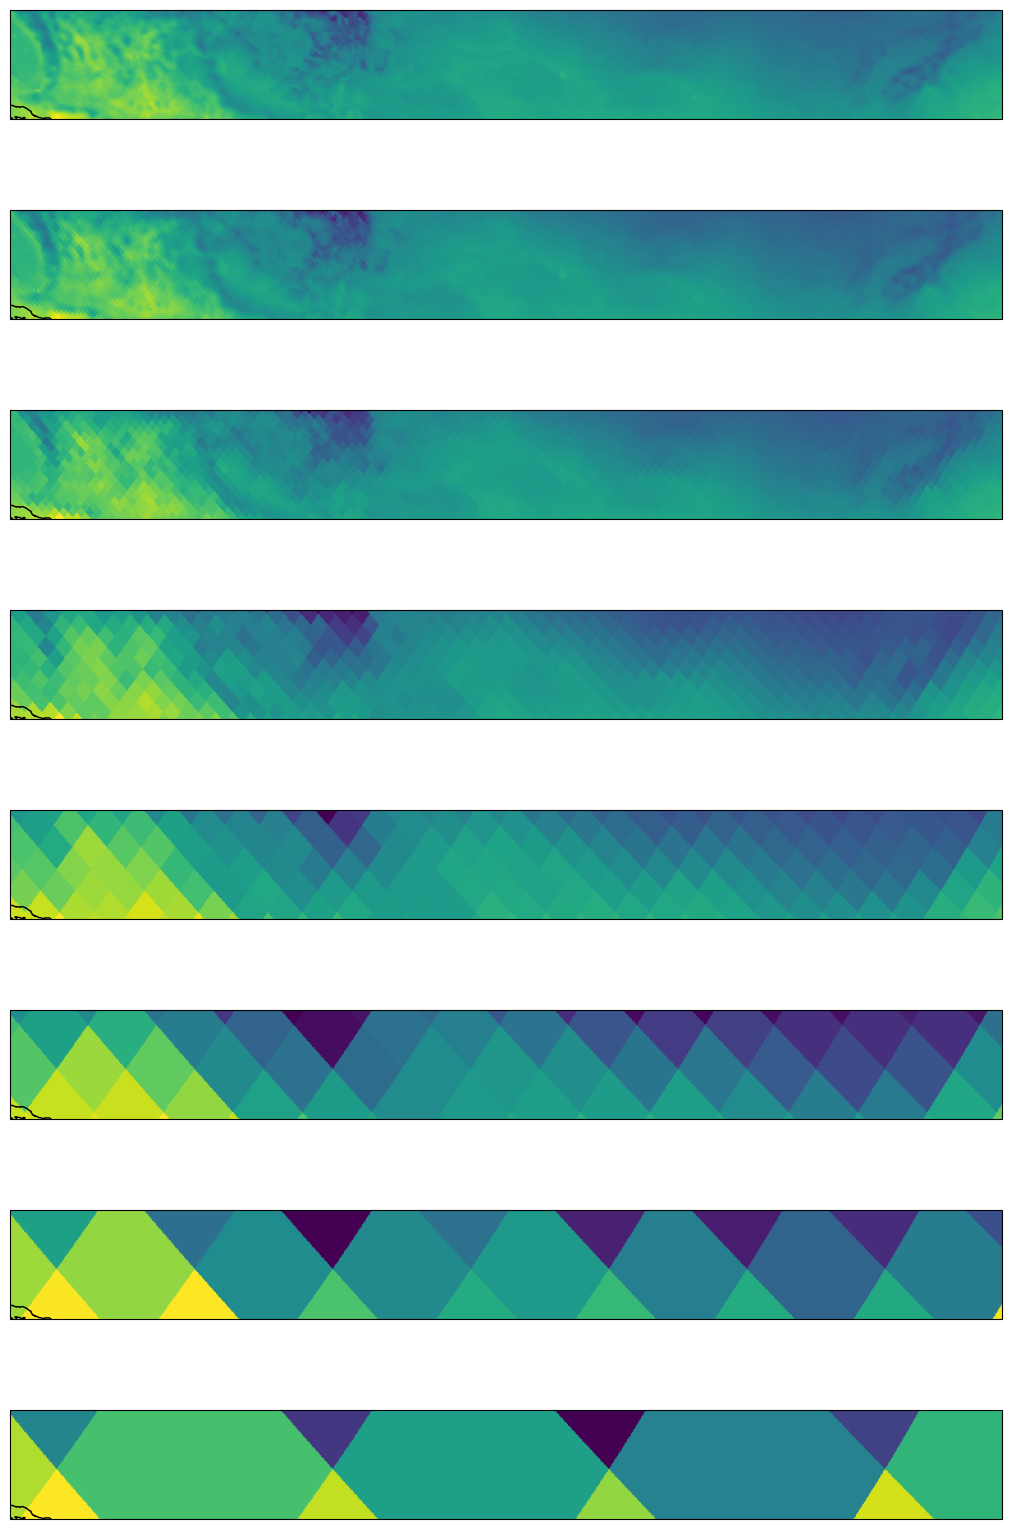

In [6]:
fig, axes = plt.subplots(len(dss), subplot_kw={'projection': ccrs.Robinson(-137)}, figsize=(10, len(dss) * 2), layout='constrained')
for ax, (z, ds) in zip(axes, dss.items()):
    ax.set_extent((-120, -80, 34, 36))
    egh.healpix_show(ds.tas.isel(time=1), ax=ax)
    ax.coastlines()

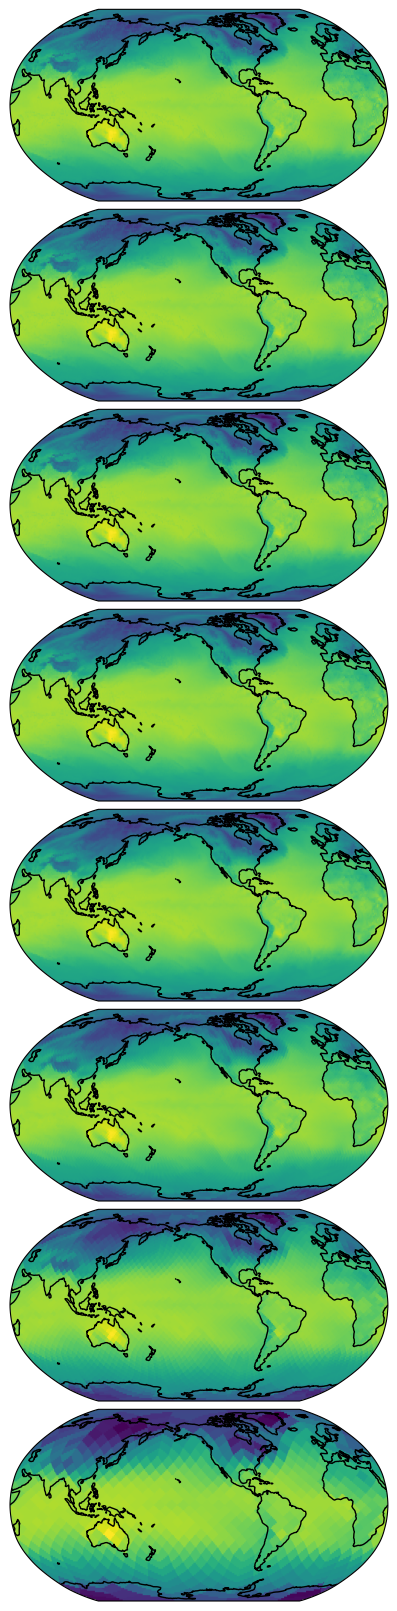

In [7]:
fig, axes = plt.subplots(len(dss), subplot_kw={'projection': ccrs.Robinson(-137)}, figsize=(10, len(dss) * 2), layout='constrained')
for ax, (z, ds) in zip(axes, dss.items()):
    ax.set_global()
    egh.healpix_show(ds.tas.sel(time='2021-02-03 04:00'), ax=ax)
    ax.coastlines()

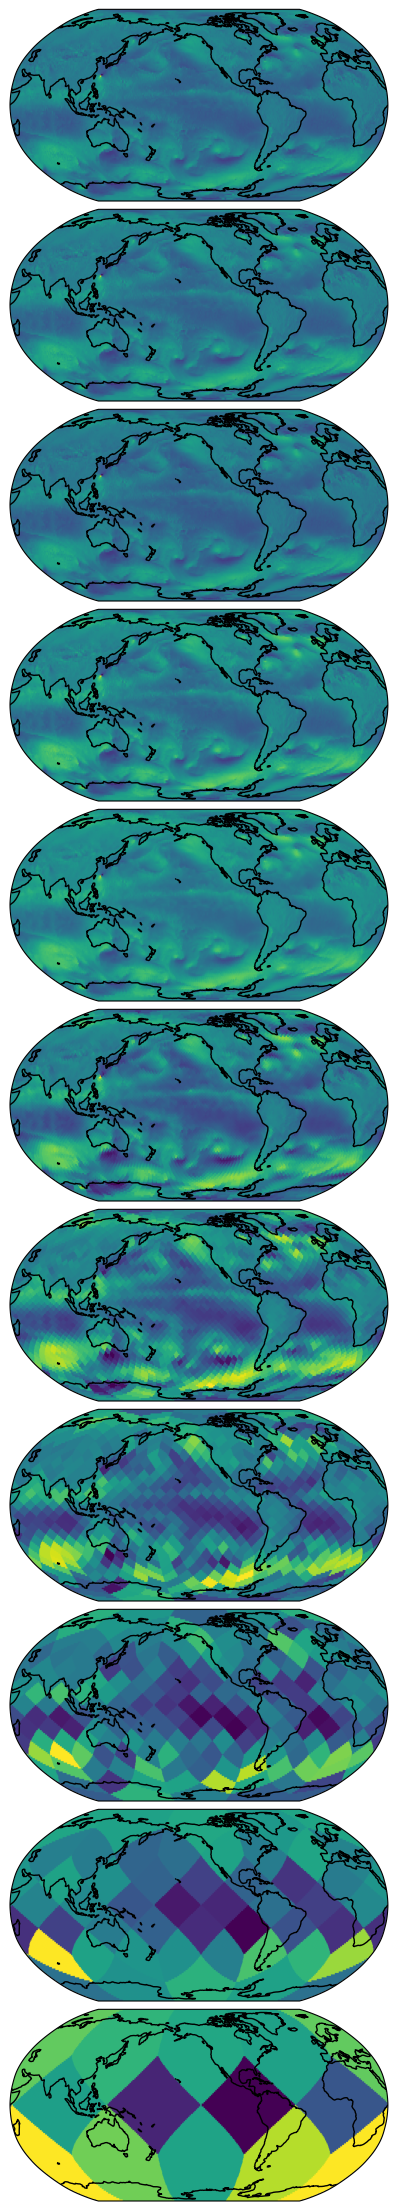

In [29]:
fig, axes = plt.subplots(len(dss), subplot_kw={'projection': ccrs.Robinson(-137)}, figsize=(10, len(dss) * 2), layout='constrained')
for ax, (z, ds) in zip(axes, dss.items()):
    ax.set_global()
    egh.healpix_show(ds.uas.sel(time='2020-09-21 23:00'), ax=ax)
    ax.coastlines()

In [28]:
ds

<xarray.Dataset> Size: 13TB
Dimensions:  (cell: 12582912, time: 10489)
Coordinates:
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    crs      float64 8B ...
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
Data variables: (12/24)
    clivi    (time, cell) float32 528GB ...
    clt      (time, cell) float32 528GB ...
    clwvi    (time, cell) float32 528GB ...
    hflsd    (time, cell) float32 528GB ...
    hfssd    (time, cell) float32 528GB ...
    huss     (time, cell) float32 528GB ...
    ...       ...
    rsut     (time, cell) float32 528GB ...
    rsutcs   (time, cell) float32 528GB ...
    tas      (time, cell) float32 528GB ...
    ts       (time, cell) float32 528GB ...
    uas      (time, cell) float32 528GB ...
    vas      (time, cell) float32 528GB ...
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n2560_RAL3p3
    simulation_description:           The MetUM uses a regular lat-lon grid, ...

In [ ]:
import sys
sys.path.insert(0, '/home/users/mmuetz/deploy/wcrp_hackathon/scripts/convert_latlon_pp_to_hp_nc')
from processing_config import processing_config

In [ ]:
sims = [
    'glm.n1280_CoMA9',
    'glm.n2560_RAL3p3',
    'glm.n1280_GAL9_nest',
    'SAmer_km4p4_RAL3P3.n1280_GAL9_nest',
    'Africa_km4p4_RAL3P3.n1280_GAL9_nest',
    'SEA_km4p4_RAL3P3.n1280_GAL9_nest',
    'SAmer_km4p4_CoMA9_TBv1.n1280_GAL9_nest',
    'Africa_km4p4_CoMA9_TBv1.n1280_GAL9_nest',
    'SEA_km4p4_CoMA9_TBv1.n1280_GAL9_nest',
    'CTC_km4p4_RAL3P3.n1280_GAL9_nest',
    'CTC_km4p4_CoMA9_TBv1.n1280_GAL9_nest'
]

In [ ]:
import math as maths

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import easygems.healpix as egh

In [ ]:
class Item:
    def __init__(self, url):
        self.url = url

    def to_dataset(self):
        return xr.open_zarr(self.url)

class Catalog:
    url_tpl = 'http://hackathon-o.s3.jc.rl.ac.uk/sim-data/dev/{sim}/v4/data.healpix.{freq}.z{zoom}.zarr'
    allowed_params = {
        'sim': sims,
        'freq': ['PT1H', 'PT3H'],
        'zoom': list(range(11)),
    }
    def __call__(self, **kwargs):
        for k, v in kwargs.items():
            if k not in self.allowed_params:
                raise Exception(f'Unknown param: {k}, must be one of {self.allowed_params.keys()}')
            if v not in self.allowed_params[k]:
                raise Exception(f'Unallowed param value: {v}, must be one of {self.allowed_params[k]}')
            
        return Item(self.url_tpl.format(**kwargs))

In [ ]:
cat = Catalog()

In [ ]:
ds = cat(sim=sims[1], freq='PT1H', zoom=5).to_dataset()

In [ ]:
(~np.isnan(ds.tas.mean(dim='cell').compute().values)).sum()

In [ ]:
for name, da in ds.data_vars.items():
    print(name, float((~np.isnan(da.mean(dim='cell').compute().values)).sum()))

In [ ]:
ds2 = cat(sim=sims[1], freq='PT3H', zoom=10).to_dataset()

In [ ]:
print(ds2.isel(time=slice(4)))

In [ ]:
ds2.cli.isel(time=slice(4), pressure=0).mean(dim='cell').compute()

In [ ]:
ds2.isel(time=slice(4)).coarsen(cell=4).mean().compute()